# Data Challenge - Bike Sharing Demand Prediction

# Team 1142 (Kaggle name) -  Team 22 (Aueb Eclass name)
Μελής Αλέξανδρος 3150102  
Μπιλόρογλου Ζήσης 3150117  
Φουρφουρής Ιωάννης 3150190

## Dataset Information
Our training dataset contains information from 12,165 hours over 731 days with 14 features (information categories)  and 1 target for each hour.
The file named *train.csv* contains the training set of the problem, while the file *test.csv* contains the test set of the problem. Each line of these two files corresponds to a bike sharing record characterized by the following variables:
Variable | Description
--- | --- | ---
season | season (1:winter, 2:spring, 3:summer, 4:fall)
yr | year (0: 2011, 1:2012)
mnth | month (1 to 12)
hr | hour (0 to 23)
holiday | weather day is holiday or not
weekday|day of the week
workingday | if day is neither weekend nor holiday is 1, otherwise is 0.
weathersit | 1: Clear, Few clouds, Partly cloudy, Partly cloudy
| 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
| 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
| 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
temp | Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
atemp | Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
hum | Normalized humidity. The values are divided to 100 (max)
windspeed | Normalized wind speed. The values are divided to 67 (max)
casual | count of casual users
registered | count of registered users
cnt | count of total rental bikes including both casual and registered
The training set contains the variable `cnt` which is related to the number of bicycles rented in any given 1 hour time-period. The `cnt` (and also `casual` and `registered` which obviously contain direct information about the bike sharing count) variable is missing from the test set as it is the variable to be predicted.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from scipy import stats
from numpy import median
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor,VotingRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# Reading training data from the local storage
filename = 'train.csv' 
df_train = pd.read_csv(filename)
print(df_train.shape)
df_train.head(5)

(12165, 15)


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,0.3582,7,15,22
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,0.2537,9,59,68
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,0.1940,74,270,344
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,0.1642,3,219,222
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,0.2985,30,180,210


Rename Column Names

In [3]:
df_train.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)
df_train.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,0.3582,7,15,22
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,0.2537,9,59,68
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,0.1940,74,270,344
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,0.1642,3,219,222
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,0.2985,30,180,210


Some data types need to be changed from numerical to categorical in order for the model to interpret better these variables. After some tries we found that these variables optimize better our model.

In [4]:
#Convert to object type
df_train['season'] = df_train.season.astype('object')
#df_train['year'] = df_train.year.astype('object')
#df_train['month'] = df_train.month.astype('object')
#df_train['hour'] = df_train.hour.astype('object')
df_train['holiday'] = df_train.holiday.astype('object')
df_train['weekday'] = df_train.weekday.astype('object')
df_train['workingday'] = df_train.workingday.astype('object')
#df_train['weather'] = df_train.weather.astype('object')

df_train.dtypes

season         object
year            int64
month           int64
hour            int64
holiday        object
weekday        object
workingday     object
weather         int64
temp          float64
atemp         float64
humidity      float64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

###  Exploratory Data Analysis

Analyze the change in bike sharing pattern (`count` variable) with categorical variables:

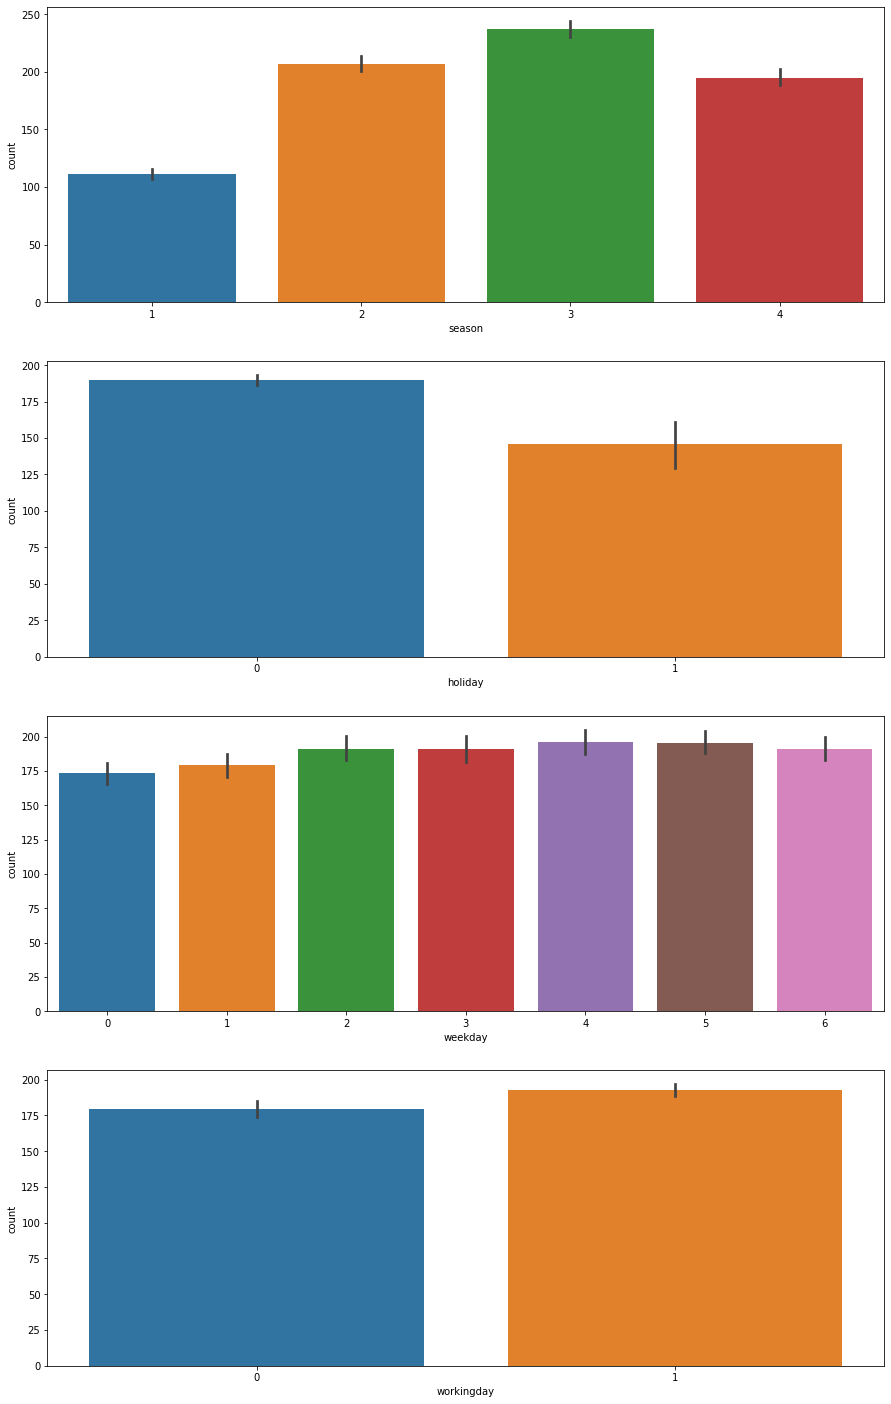

In [5]:
fig,[ax1,ax2,ax3,ax4] = plt.subplots(nrows=4, figsize=(15,25))
sn.barplot(x = df_train['season'], y = df_train['count'],ax = ax1)
sn.barplot(x = df_train['holiday'], y = df_train['count'],ax = ax2)
sn.barplot(x = df_train['weekday'], y = df_train['count'],ax = ax3)
sn.barplot(x = df_train['workingday'], y = df_train['count'],ax = ax4)

### Correlation Analysis

To see how numerical variables are connected with each other, data correlation can be checked:

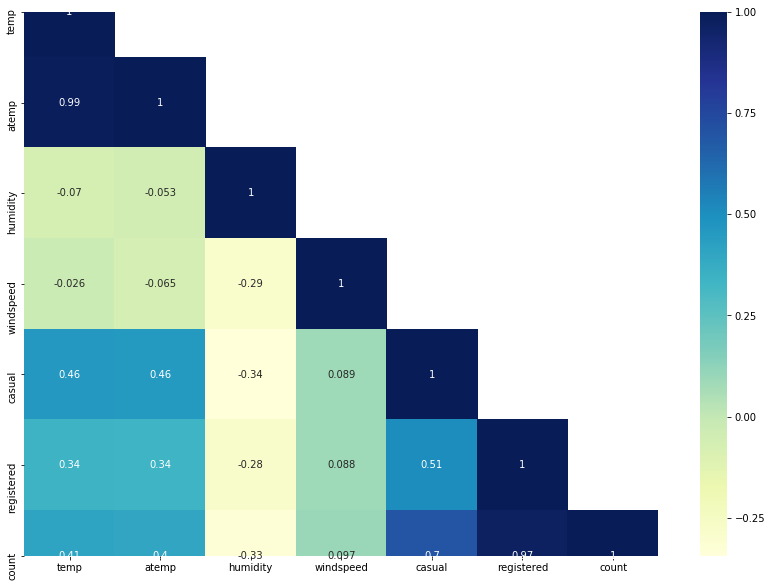

In [6]:
data_corr = df_train[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']].corr()
mask = np.array(data_corr)
mask[np.tril_indices_from(mask)] = False
fig = plt.subplots(figsize=(15, 10))
sn.heatmap(data_corr, mask=mask, vmax=1, square=True, annot=True, cmap="YlGnBu")

It can be observed that:
- `temp` and `atemp` are strongly correlated. To reduce the dimensionality of the predictive model, the feature `temp` is dismissed.
- `casual` and `registered` contain direct information about the bike sharing `count` which we want to predict (data leakage). Therefore they are not considered in the feature set.
- `atemp` has positive correlation and `humidity` has negative correlation with `count`.
- `windspeed` has little correlation with `count`.
- The variables `hour` and `atemp` seem to be promising features for the bike sharing count prediction.

# Model building

In [7]:
#Drop columns casual, registered, windspeed
df_train = df_train.drop(['casual', 'registered', 'windspeed'], axis=1)
df_train.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,count
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,22
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,68
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,344
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,222
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,210


In [8]:
#Training data
X = df_train[['season','year','month','hour','holiday','weekday','workingday','weather','atemp','humidity']]

#One-hot encoding technique for better performance
X = pd.get_dummies(X)

#Set the target
y = df_train['count']

#Data split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
#Print shapes
print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (9732, 21)
y_train shape:  (9732,)
X_test shape:  (2433, 21)
y_test shape:  (2433,)


We first start testing the performance of different regression algorithms.

In [10]:
#Initialize models
models=[ExtraTreesRegressor(),RandomForestRegressor(),AdaBoostRegressor(),KNeighborsRegressor(), xgb.XGBRegressor(),DecisionTreeRegressor(),GradientBoostingRegressor()]
model_names=['ExtraTreeRegressor','RandomForestRegressor','AdaBoostRegressor','KNeighborsRegressor','XGBRegressor','DecisionTreeRegressor','GradientBoostingRegressor']
rmsle=[]
d={}

#Fit and predict
for model in range (len(models)):
    clf=models[model]
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    for i, _  in enumerate(y_pred):
        if y_pred[i] < 0:
            y_pred[i] = 0
    rmsle.append(np.sqrt(mean_squared_log_error(y_pred,y_test)))
    
#Create DataFrame from Model,RMSLE
d={'Modelling Algo':model_names,'RMSLE':rmsle}   
rmsle_frame=pd.DataFrame(d)
rmsle_frame

C:\Users\GiannisF\Anaconda3\envs\tensorflow_gpu\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:37:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Modelling Algo,RMSLE
0,ExtraTreeRegressor,0.332194
1,RandomForestRegressor,0.341957
2,AdaBoostRegressor,1.076924
3,KNeighborsRegressor,0.414965
4,XGBRegressor,0.768123
5,DecisionTreeRegressor,0.469315
6,GradientBoostingRegressor,0.745488


C:\Users\GiannisF\Anaconda3\envs\tensorflow_gpu\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\GiannisF\Anaconda3\envs\tensorflow_gpu\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


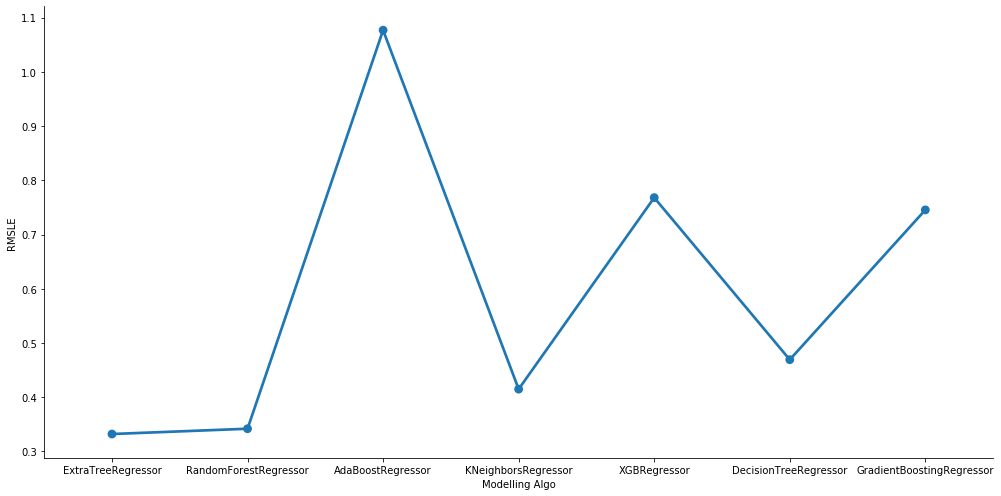

In [11]:
sn.factorplot(x='Modelling Algo',y='RMSLE',data=rmsle_frame,kind='point',size=7,aspect=2)

We see that ExtraTreesRegressor has the best RMSLE score so we start with it. We want to find the best parameters so we use GridSearchCV.

In [12]:
#Initialize ExtraTreesRegressor
clf = ExtraTreesRegressor()

#Initialize params
param_grid = {
    'n_estimators': [200,300,500],
    'n_jobs':[-1],
    'random_state':[42,62,52],
    'min_samples_split': [2,3,4],
    'max_depth': [100,200,300]
}
#Initialize GridSearchCV
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, verbose = 2)

#Fit GridSearchCV
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] max_depth=100, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=100, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42, total=   3.1s
[CV] max_depth=100, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV]  max_depth=100, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42, total=   2.3s
[CV] max_depth=100, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=100, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42, total=   2.3s
[CV] max_depth=100, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=100, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42, total=   2.3s
[CV] max_depth=100, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=100, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42, total=   2.3s
[CV] max_depth=100, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=62 
[CV]  max_depth=100, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=62, total=   2.3s
[CV] max_depth=100, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=62 
[CV]  max_depth=100, min_samples_split=2, n_estimators=

[CV]  max_depth=100, min_samples_split=3, n_estimators=200, n_jobs=-1, random_state=42, total=   1.9s
[CV] max_depth=100, min_samples_split=3, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=100, min_samples_split=3, n_estimators=200, n_jobs=-1, random_state=42, total=   1.9s
[CV] max_depth=100, min_samples_split=3, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=100, min_samples_split=3, n_estimators=200, n_jobs=-1, random_state=42, total=   1.9s
[CV] max_depth=100, min_samples_split=3, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=100, min_samples_split=3, n_estimators=200, n_jobs=-1, random_state=42, total=   1.9s
[CV] max_depth=100, min_samples_split=3, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=100, min_samples_split=3, n_estimators=200, n_jobs=-1, random_state=42, total=   1.9s
[CV] max_depth=100, min_samples_split=3, n_estimators=200, n_jobs=-1, random_state=62 
[CV]  max_depth=100, min_samples_split=3, n_estimators=

[CV]  max_depth=100, min_samples_split=3, n_estimators=500, n_jobs=-1, random_state=52, total=   4.6s
[CV] max_depth=100, min_samples_split=4, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=100, min_samples_split=4, n_estimators=200, n_jobs=-1, random_state=42, total=   1.8s
[CV] max_depth=100, min_samples_split=4, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=100, min_samples_split=4, n_estimators=200, n_jobs=-1, random_state=42, total=   1.8s
[CV] max_depth=100, min_samples_split=4, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=100, min_samples_split=4, n_estimators=200, n_jobs=-1, random_state=42, total=   1.7s
[CV] max_depth=100, min_samples_split=4, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=100, min_samples_split=4, n_estimators=200, n_jobs=-1, random_state=42, total=   1.7s
[CV] max_depth=100, min_samples_split=4, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=100, min_samples_split=4, n_estimators=

[CV]  max_depth=100, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52, total=   4.4s
[CV] max_depth=100, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=100, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52, total=   4.1s
[CV] max_depth=200, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=200, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42, total=   2.3s
[CV] max_depth=200, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=200, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42, total=   2.2s
[CV] max_depth=200, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=200, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42, total=   2.3s
[CV] max_depth=200, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=200, min_samples_split=2, n_estimators=

[CV]  max_depth=200, min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=52, total=   5.3s
[CV] max_depth=200, min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=200, min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=52, total=   5.3s
[CV] max_depth=200, min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=200, min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=52, total=   5.3s
[CV] max_depth=200, min_samples_split=3, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=200, min_samples_split=3, n_estimators=200, n_jobs=-1, random_state=42, total=   1.9s
[CV] max_depth=200, min_samples_split=3, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=200, min_samples_split=3, n_estimators=200, n_jobs=-1, random_state=42, total=   1.9s
[CV] max_depth=200, min_samples_split=3, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=200, min_samples_split=3, n_estimators=

[CV]  max_depth=200, min_samples_split=3, n_estimators=500, n_jobs=-1, random_state=52, total=   4.7s
[CV] max_depth=200, min_samples_split=3, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=200, min_samples_split=3, n_estimators=500, n_jobs=-1, random_state=52, total=   4.6s
[CV] max_depth=200, min_samples_split=3, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=200, min_samples_split=3, n_estimators=500, n_jobs=-1, random_state=52, total=   4.6s
[CV] max_depth=200, min_samples_split=3, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=200, min_samples_split=3, n_estimators=500, n_jobs=-1, random_state=52, total=   4.6s
[CV] max_depth=200, min_samples_split=4, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=200, min_samples_split=4, n_estimators=200, n_jobs=-1, random_state=42, total=   1.7s
[CV] max_depth=200, min_samples_split=4, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=200, min_samples_split=4, n_estimators=

[CV]  max_depth=200, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52, total=   4.3s
[CV] max_depth=200, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=200, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52, total=   4.2s
[CV] max_depth=200, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=200, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52, total=   4.1s
[CV] max_depth=200, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=200, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52, total=   4.1s
[CV] max_depth=200, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=200, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52, total=   4.1s
[CV] max_depth=300, min_samples_split=2, n_estimators=200, n_jobs=-1, random_state=42 
[CV]  max_depth=300, min_samples_split=2, n_estimators=

[CV]  max_depth=300, min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=62, total=   5.3s
[CV] max_depth=300, min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=300, min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=52, total=   5.4s
[CV] max_depth=300, min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=300, min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=52, total=   5.4s
[CV] max_depth=300, min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=300, min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=52, total=   5.5s
[CV] max_depth=300, min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=300, min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=52, total=   5.3s
[CV] max_depth=300, min_samples_split=2, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=300, min_samples_split=2, n_estimators=

[CV]  max_depth=300, min_samples_split=3, n_estimators=500, n_jobs=-1, random_state=62, total=   4.6s
[CV] max_depth=300, min_samples_split=3, n_estimators=500, n_jobs=-1, random_state=62 
[CV]  max_depth=300, min_samples_split=3, n_estimators=500, n_jobs=-1, random_state=62, total=   4.7s
[CV] max_depth=300, min_samples_split=3, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=300, min_samples_split=3, n_estimators=500, n_jobs=-1, random_state=52, total=   4.6s
[CV] max_depth=300, min_samples_split=3, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=300, min_samples_split=3, n_estimators=500, n_jobs=-1, random_state=52, total=   4.7s
[CV] max_depth=300, min_samples_split=3, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=300, min_samples_split=3, n_estimators=500, n_jobs=-1, random_state=52, total=   4.6s
[CV] max_depth=300, min_samples_split=3, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=300, min_samples_split=3, n_estimators=

[CV]  max_depth=300, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=62, total=   4.1s
[CV] max_depth=300, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=62 
[CV]  max_depth=300, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=62, total=   4.1s
[CV] max_depth=300, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=62 
[CV]  max_depth=300, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=62, total=   4.1s
[CV] max_depth=300, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=300, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52, total=   4.1s
[CV] max_depth=300, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=300, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52, total=   4.2s
[CV] max_depth=300, min_samples_split=4, n_estimators=500, n_jobs=-1, random_state=52 
[CV]  max_depth=300, min_samples_split=4, n_estimators=

[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 21.6min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=None,
                                           oob_score=False, random_state=None,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             

In [13]:
#Find the best params
print(grid_search.best_params_)

#Find the best estimator
best_grid = grid_search.best_estimator_

#Fit with the best params
best_grid.fit(X_train, y_train)

#Predict
y_pred = best_grid.predict(X_test)

#If predicted value is negative then we set it zero.
for i, _  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0

#Print RMSLE Score
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))

{'max_depth': 100, 'min_samples_split': 4, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 52}
RMSLE: 0.3305973730187315


[Text(0.5, 1.0, 'Comparison between the actual vs predicted values')]

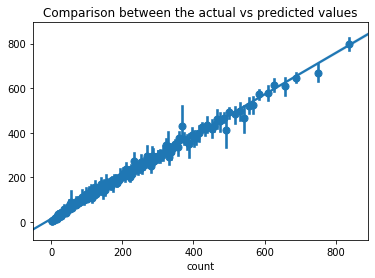

In [14]:
#Plot comparison between the actual versus the predicted value
ax = sn.regplot(y_test, y_pred, x_bins = 200)
ax.set(title = "Comparison between the actual vs predicted values")

We also tested PCA, SVD for dimensionality reduction, but we didn't see any imrovement, so we didn't include it in this notebook.

Then tested Voting Regressor which use not so good algorithms, but the combination of them gives a very good result.

In [15]:
# Use best parameters found before
rf = RandomForestRegressor()
dt = DecisionTreeRegressor()

#Voting
vr = VotingRegressor(estimators=[('rf', rf), ('dt', dt)], n_jobs=-1)
vr.fit(X_train, y_train)
#Prediction
y_pred = vr.predict(X_test)
for i, _  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0
print('RMSLE: ', (np.sqrt(mean_squared_log_error(y_pred,y_test))))

RMSLE:  0.3735147850779171


With all the above we had a 0,30 Rmsle score at Kaggle's leaderboard. So we decided to use Neural Network.

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

print(tf.__version__)

C:\Users\GiannisF\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\GiannisF\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\GiannisF\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\GiannisF\Anaconda3\envs\tens

1.14.0


C:\Users\GiannisF\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\GiannisF\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\GiannisF\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Giannis

In [17]:
#Define our loss
def RMSLE(y_true, y_pred):
        return K.sqrt(K.mean((K.log(1+y_pred) - K.log(1+y_true))**2))

For the number of layers and the unit size we tested a lot of combinations and we ended up with the following.

In [18]:
#Initialize a Sequential model
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(1024, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(1024, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss=RMSLE, optimizer='adam', metrics=[RMSLE])
NN_model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              22528     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 810,753
Trainable params: 810,753
Non-trainable params: 0
________________________________________________________________

In [19]:
#We create checkpoint to keep all the epoch results and get the best one.
checkpoint_name = 'Weights/Weights-{epoch:03d}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss')
callbacks_list = [EarlyStopping(monitor='val_loss', patience=50),checkpoint] #We use early stopping

In [20]:
#If the Weight file contains file then i delete them to keep the new ones.
import os
Weights=os.listdir("Weights")
for j in range(len(Weights)):
    os.remove('Weights/'+ Weights[j])

In [21]:
#Fit the model.
history=NN_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 7785 samples, validate on 1947 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/200
7785/7785 [==============================] - 1s 182us/sample - loss: 0.9396 - RMSLE: 0.9381 - val_loss: 0.6800 - val_RMSLE: 0.6798
Epoch 2/200
7785/7785 [==============================] - 1s 129us/sample - loss: 0.6084 - RMSLE: 0.6080 - val_loss: 0.5734 - val_RMSLE: 0.5735
Epoch 3/200
7785/7785 [==============================] - 1s 127us/sample - loss: 0.5266 - RMSLE: 0.5267 - val_loss: 0.5151 - val_RMSLE: 0.5153
Epoch 4/200
7785/7785 [==============================] - 1s 128us/sample - loss: 0.4940 - RMSLE: 0.4943 - val_loss: 0.4945 - val_RMSLE: 0.4942
Epoch 5/200
7785/7785 [==============================] - 1s 126us/sample - loss: 0.4774 - RMSLE: 0.4772 - val_loss: 0.4707 - val_RMSLE: 0.4705
Epoch 6/200
7785/7785 [==============================] - 1s 126us/sample - loss: 0.4556 - RMSLE: 0.4559 - val_loss: 0.4374 - val_RMSLE: 0.4377


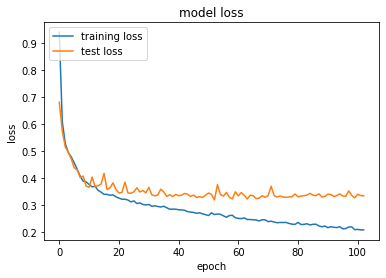

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'test loss'], loc='upper left')
plt.show()

In [23]:
#Open and read Weights file.
Weights=os.listdir("Weights")

#For min_bound until the last epoch compute RMSLE score for X_test
min_bound=len(Weights)-20

#Create numpy array to store epoch and RMSLE
weights_final=np.zeros([len(Weights),2])

#Compute and store poch and RMSLE
for j in range(min_bound,len(Weights)):
    wights_file = 'Weights/'+ Weights[j] #choose checkpoint 
    NN_model.load_weights(wights_file) #load it
    NN_model.compile(loss=RMSLE, optimizer='adam', metrics=[RMSLE])
    y_pred = NN_model.predict(X_test)
    for i, _  in enumerate(y_pred):
        if y_pred[i] < 0:
            y_pred[i] = 0
    weights_final[j][0]=j #Store epoch
    weights_final[j][1]=np.sqrt(mean_squared_log_error(y_test, y_pred)) #Store Rmsle

In [24]:
#Delete the row with zeros
weights_final=np.delete(weights_final,range(0,min_bound), axis=0)

#Sort by RMSLE
weights_final=weights_final[weights_final[:,1].argsort()]

In [25]:
#Print results
for j in range(0,len(weights_final)):
    print(str(weights_final[j][0])+' RMSLE:', str(weights_final[j][1]))

102.0 RMSLE: 0.3108014728620219
99.0 RMSLE: 0.31303929709196565
101.0 RMSLE: 0.3155660139809817
92.0 RMSLE: 0.31610106685540673
95.0 RMSLE: 0.316345319224576
88.0 RMSLE: 0.31653374010013724
100.0 RMSLE: 0.31657660684367883
86.0 RMSLE: 0.31711850494052174
93.0 RMSLE: 0.31723174025461925
89.0 RMSLE: 0.31771274420712686
91.0 RMSLE: 0.31932777047334565
96.0 RMSLE: 0.3240954184371485
87.0 RMSLE: 0.324832307672934
94.0 RMSLE: 0.32487440480761737
98.0 RMSLE: 0.3261364083591848
85.0 RMSLE: 0.32832501582419976
83.0 RMSLE: 0.32858318933444597
90.0 RMSLE: 0.32869918625254263
84.0 RMSLE: 0.3327352637145666
97.0 RMSLE: 0.3365536886527242


In [26]:
wights_file = 'Weights/'+ Weights[int(weights_final[0][0])] #Choose the best checkpoint 
NN_model.load_weights(wights_file) #Load it
NN_model.compile(loss=RMSLE, optimizer='adam', metrics=[RMSLE]) #Compile it

Moreover, we use ensembles in order to combine predictions from different models to generate a final prediction. So, we create some methods which facilitate the fuctionality of the ensembles. 
First, the method get_models() returns a list that contains the different models for use.

In [27]:
def get_models():
    
    #generate base learners
    
    rfr = RandomForestRegressor(n_estimators=500)
    rfr2 = RandomForestRegressor(n_estimators = 800)
    rfr3 = RandomForestRegressor(n_estimators = 300)
    etr = ExtraTreesRegressor(n_estimators=800)
    etr2 = ExtraTreesRegressor(n_estimators = 600)
    NN_model = Sequential()

    # The Input Layer :
    NN_model.add(Dense(1024, kernel_initializer='normal',input_dim = X.shape[1], activation='relu'))
    # The Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(1024, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    # Compile the network :
    NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    NN_model.summary()
 
    models ={
        'rfr':rfr,
        'rfr2':rfr2,
        'rfr3':rfr3,
        'etr':etr,
        'etr2':etr2,
        'NN_model':NN_model
    }
    
    return models

models = get_models()
print('Models are ready...')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              22528     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 810,753
Trainable params: 810,753
Non-trainable params: 0
_________________________________________________________________
Models are ready...


Then, train_predict() is used to fit each model with (X_train,y_train) and make predictions with X_test data. The predictions of every model are inserted at a numpy array (Predictions).

In [28]:
def train_predict(model_list,Xtrain,ytrain,Xtest,ytest):
    #fit models in list on training set and return predictions
    Predictions = np.zeros((Xtest.shape[0],len(model_list)))
    Predictions = pd.DataFrame(Predictions)
    
    print("Fitting models")
    
    cols=list()
    for i,(name,model) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        if(name!="NN_model"):
            model.fit(Xtrain, ytrain) 
            p = model.predict(Xtest)[:]
            Predictions.iloc[:,i]=p
            cols.append(name)
            print("done")
        else:
            model.fit(Xtrain, ytrain, epochs=150, batch_size=64, validation_split = 0.2) 
            p = model.predict(Xtest)[:]
            Predictions.iloc[:,i]=p
            cols.append(name)
            print("done")
        
        
        
    Predictions.columns = cols
    print("Done.\n")
    return Predictions

P = train_predict(models,X_train,y_train,X_test,y_test)

Fitting models
rfr... done
rfr2... done
rfr3... done
etr... done
etr2... done
NN_model... Train on 7785 samples, validate on 1947 samples
Epoch 1/150
7785/7785 [==============================] - 1s 100us/sample - loss: 110.8657 - mean_absolute_error: 110.8658 - val_loss: 84.0210 - val_mean_absolute_error: 84.0210
Epoch 2/150
7785/7785 [==============================] - 1s 67us/sample - loss: 83.9731 - mean_absolute_error: 83.9731 - val_loss: 72.5098 - val_mean_absolute_error: 72.5098
Epoch 3/150
7785/7785 [==============================] - 1s 70us/sample - loss: 74.7167 - mean_absolute_error: 74.7167 - val_loss: 66.7468 - val_mean_absolute_error: 66.7468
Epoch 4/150
7785/7785 [==============================] - 1s 68us/sample - loss: 68.6337 - mean_absolute_error: 68.6337 - val_loss: 61.7285 - val_mean_absolute_error: 61.7285
Epoch 5/150
7785/7785 [==============================] - 1s 67us/sample - loss: 64.3087 - mean_absolute_error: 64.3087 - val_loss: 57.9563 - val_mean_absolute_erro

7785/7785 [==============================] - 1s 68us/sample - loss: 27.9804 - mean_absolute_error: 27.9804 - val_loss: 31.7930 - val_mean_absolute_error: 31.7930
Epoch 48/150
7785/7785 [==============================] - 1s 65us/sample - loss: 28.1556 - mean_absolute_error: 28.1556 - val_loss: 29.2493 - val_mean_absolute_error: 29.2493
Epoch 49/150
7785/7785 [==============================] - 1s 68us/sample - loss: 27.2624 - mean_absolute_error: 27.2624 - val_loss: 28.1584 - val_mean_absolute_error: 28.1584
Epoch 50/150
7785/7785 [==============================] - 1s 67us/sample - loss: 27.3356 - mean_absolute_error: 27.3356 - val_loss: 31.3147 - val_mean_absolute_error: 31.3147
Epoch 51/150
7785/7785 [==============================] - 1s 67us/sample - loss: 28.1534 - mean_absolute_error: 28.1534 - val_loss: 28.3808 - val_mean_absolute_error: 28.3808
Epoch 52/150
7785/7785 [==============================] - 1s 69us/sample - loss: 27.1121 - mean_absolute_error: 27.1121 - val_loss: 30.566

Epoch 94/150
7785/7785 [==============================] - 1s 69us/sample - loss: 23.0628 - mean_absolute_error: 23.0628 - val_loss: 27.0783 - val_mean_absolute_error: 27.0783
Epoch 95/150
7785/7785 [==============================] - 1s 70us/sample - loss: 23.0311 - mean_absolute_error: 23.0311 - val_loss: 31.1981 - val_mean_absolute_error: 31.1981
Epoch 96/150
7785/7785 [==============================] - 1s 70us/sample - loss: 24.2614 - mean_absolute_error: 24.2615 - val_loss: 26.1230 - val_mean_absolute_error: 26.1230
Epoch 97/150
7785/7785 [==============================] - 1s 70us/sample - loss: 22.4423 - mean_absolute_error: 22.4423 - val_loss: 26.0532 - val_mean_absolute_error: 26.0532
Epoch 98/150
7785/7785 [==============================] - 1s 72us/sample - loss: 22.9942 - mean_absolute_error: 22.9942 - val_loss: 26.4082 - val_mean_absolute_error: 26.4082
Epoch 99/150
7785/7785 [==============================] - 1s 71us/sample - loss: 23.4331 - mean_absolute_error: 23.4331 - val

The score_models() method takes as arguments the Predictions array and y_test data in order to score each model. Finally, we combine the predictions by applying the mean function at every row of the Predictions array, and we calculate the RMSLE score.

In [29]:
def score_models(Predictions,y):
    #score model in prediction df
    print("Scoring models.")
    for model in Predictions.columns:
        for i,_ in enumerate(y):
            if Predictions.loc[i,model]<0:
                Predictions.loc[i,model]=0
        print('RMSLE '+model+' :', np.sqrt(mean_squared_log_error(y, Predictions.loc[:,model])))
    print("Done. \n")
    
score_models(P,y_test)

mean_predict = P.mean(axis=1)
print('RMSLE mean_predictions :', np.sqrt(mean_squared_log_error(y_test, mean_predict)))

Scoring models.
RMSLE rfr : 0.3434604978871128
RMSLE rfr2 : 0.3421935797295119
RMSLE rfr3 : 0.34374524942385826
RMSLE etr : 0.33248658870374426
RMSLE etr2 : 0.3309408791869412
RMSLE NN_model : 0.3078330224262787
Done. 

RMSLE mean_predictions : 0.31775344574185255


To create submission.csv we train the model to the whole training set.

# Kaggle Submission

Now we will use the fitted model to make predictions for the **given** test set. First we load the test set and then follow the same preprocessing steps as for train set.

In [30]:
# Reading test data from the local storage
filename = 'test.csv' 
df_test = pd.read_csv(filename)
print(df_test.shape)
df_test.head(5)

(5214, 12)


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,1,1,20,0,4,1,1,0.26,0.2121,0.52,0.4478
1,4,1,10,15,0,5,1,1,0.52,0.5000,0.42,0.4478
2,1,0,1,10,0,0,0,1,0.22,0.2121,0.51,0.2836
3,3,1,8,18,0,3,1,1,0.74,0.6667,0.51,0.2239
4,1,1,2,8,0,1,1,1,0.24,0.2424,0.60,0.0000


Whatever preprocessing we did to training data, we have to do also to test data.

Rename Column Names

In [31]:
df_test.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)
df_test.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed
0,1,1,1,20,0,4,1,1,0.26,0.2121,0.52,0.4478
1,4,1,10,15,0,5,1,1,0.52,0.5000,0.42,0.4478
2,1,0,1,10,0,0,0,1,0.22,0.2121,0.51,0.2836
3,3,1,8,18,0,3,1,1,0.74,0.6667,0.51,0.2239
4,1,1,2,8,0,1,1,1,0.24,0.2424,0.60,0.0000


In [32]:
#Convert to object type
df_test['season'] = df_test.season.astype('object')
#df_test['year'] = df_test.year.astype('object')
#df_test['month'] = df_test.month.astype('object')
#df_test['hour'] = df_test.hour.astype('object')#category
df_test['holiday'] = df_test.holiday.astype('object')
df_test['weekday'] = df_test.weekday.astype('object')
df_test['workingday'] = df_test.workingday.astype('object')
#df_test['weather'] = df_test.weather.astype('object')

df_test.dtypes

season         object
year            int64
month           int64
hour            int64
holiday        object
weekday        object
workingday     object
weather         int64
temp          float64
atemp         float64
humidity      float64
windspeed     float64
dtype: object

In [33]:
df_test = df_test.drop(['windspeed'], axis=1)
df_test.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity
0,1,1,1,20,0,4,1,1,0.26,0.2121,0.52
1,4,1,10,15,0,5,1,1,0.52,0.5000,0.42
2,1,0,1,10,0,0,0,1,0.22,0.2121,0.51
3,3,1,8,18,0,3,1,1,0.74,0.6667,0.51
4,1,1,2,8,0,1,1,1,0.24,0.2424,0.60


In [34]:
#Test data
df_test = df_test[['season','year','month','hour','holiday','weekday','workingday','weather','atemp','humidity']]

#One-hot encoding technique for better performance
df_test = pd.get_dummies(df_test)

In [35]:
#Predict
y_pred = NN_model.predict(df_test)
for i, y  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0

Prepare a pandas dataframe according to submission format and save it to `submission.csv`:

In [36]:
#We create submission.csv and write it to disk
submission = pd.DataFrame()
submission['Id'] = range(y_pred.shape[0])
submission['Predicted'] = y_pred
submission.to_csv("submission.csv", index=False)

These submission gave us a 0.28 RMSLE score at Kaggle's leaderboard. We saw that some submissions, with the same rmsle score, got different values for the same test example, so we decided to get the mean of these submissions.

In [37]:
#Read the first submission
filename1 = 'submission(0.28248).csv' 
sub1 = pd.read_csv(filename1)
print(sub1.shape)
sub1.head(5)

(5214, 2)


,Id,Predicted
0,0,161.92812
1,1,404.47858
2,2,64.59464
3,3,872.21470
4,4,478.00440


In [38]:
filename2 = 'submission(0.28074).csv' 
sub2 = pd.read_csv(filename2)
print(sub2.shape)
sub2.head(5)

(5214, 2)


,Id,Predicted
0,0,160.87960
1,1,407.11426
2,2,64.99710
3,3,855.41250
4,4,479.74610


In [39]:
#Create the mean
mean=np.zeros((sub1.shape[0],1))
for i in range(mean.shape[0]):
    mean[i][0]=(sub1['Predicted'][i]+sub2['Predicted'][i])/2
    
#Create the Predicted Column
dataset = pd.DataFrame({'Predicted': mean[:, 0]})

In [40]:
#Create the new sumbission and store it to disk
submission_mean = pd.DataFrame()
submission_mean['Id'] = range(mean.shape[0])
submission_mean['Predicted']=dataset['Predicted'][:] 
submission_mean.shape
submission_mean.to_csv("submission_mean.csv", index=False)

Our final RMSLE Score: 0.26379